Time series clustering on a dataset which contains a 20 year history of final league positions of all teams in the top four divisions of English football. The objective is to automatically group together teams that have had a similar "journey" in terms of movement up and down the league tables/divisions.

In [43]:
from kshape.core import kshape, zscore
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

In [44]:
df = pd.read_csv('data/20yearsflsam.csv', index_col=0, header=None).T
df.shape

(21, 110)

One column per team (110 teams), one row per year (20 years of history). Value is the overall position in the league pyramid, so 25.0 means 5th place in the 2nd division, as their are 20 teams in the top division.

In [45]:
df.head()

,Manchester United,Newcastle United,Arsenal,Liverpool,Aston Villa,Chelsea,Sheffield Wednesday,Wimbledon,Leicester City,Tottenham Hotspur,...,Accrington Stanley,Dagenham & Redbridge,Morecambe,Aldershot Town,Burton Albion,Stevenage Borough,Crawley Town,AFC Wimbledon,Fleetwood Town,Newport County
1,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,125.0,118.0,96.0,143.0,142.0,95.0,131.0,NaN,NaN,NaN
2,2.0,13.0,1.0,3.0,7.0,4.0,16.0,15.0,10.0,14.0,...,134.0,118.0,97.0,137.0,139.0,107.0,124.0,NaN,NaN,NaN
3,1.0,13.0,2.0,7.0,6.0,3.0,12.0,16.0,10.0,11.0,...,136.0,117.0,106.0,121.0,149.0,98.0,125.0,NaN,NaN,NaN
4,1.0,11.0,2.0,4.0,6.0,5.0,19.0,18.0,8.0,10.0,...,137.0,115.0,95.0,116.0,138.0,102.0,126.0,NaN,NaN,121.0
5,1.0,11.0,2.0,3.0,8.0,6.0,37.0,28.0,13.0,12.0,...,123.0,95.0,111.0,118.0,138.0,99.0,125.0,NaN,NaN,124.0


Remove columns with any null values (i.e. teams that did not consistently appear in top four divisions across past 20 years) 

In [46]:
df = df.loc[:, ~df.isnull().any(axis=0)] 

Invert rank to make plots more intuitive 

In [47]:
df = df * -1

Apply 3 point rolling mean to smooth the time series. This will create two null rows which we will remove

In [48]:
df = df.rolling(3).mean()
df = df.loc[~df.isnull().any(axis=1)]

Plotting examples for four different clubs, each with a very different history in terms of league position movement. The clustering objective is to group clubs with a similar history

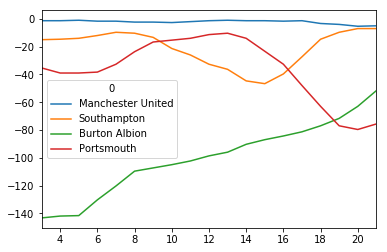

In [49]:
df[['Manchester United', 'Southampton', 'Burton Albion','Portsmouth']].plot()
plt.show()

In [50]:
def plot_all_clusters(clusters, time_series):
    ''' subplots showing centroid and z-standarized inputs for each cluster '''
    k = len(clusters)
    fig, axes = plt.subplots(nrows=int(k/2), ncols=2,figsize=(12, k))
    
    for i, ax in enumerate(axes.flatten()):
        centroid, time_series_indices = clusters[i]
        for time_series_index in time_series_indices:
            ax.plot(time_series[time_series_index])
        ax.plot(centroid, c= 'black', linewidth=2)
        ax.set_title(f'Cluster: {i}')
    plt.tight_layout()
    plt.show()
    
def plot_raw_cluster(cluster, df):
    centroid, column_indices = cluster
    df_cluster = df.iloc[:, column_indices].copy()
    df_cluster_zscore = df_cluster.apply(lambda x: zscore(x)).reset_index(drop=True)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    df_cluster.plot(ax=ax1)
    ax1.set_title('Cluster raw input')
    df_cluster_zscore.plot(ax=ax2)
    ax2.plot(centroid, c= 'black', linewidth=2)
    ax2.set_title('Cluster standardized input (z-score) with centroid')
    plt.show()

Running k-shape clustering and plotting each timeseries in the cluster, along with the cluster centroid

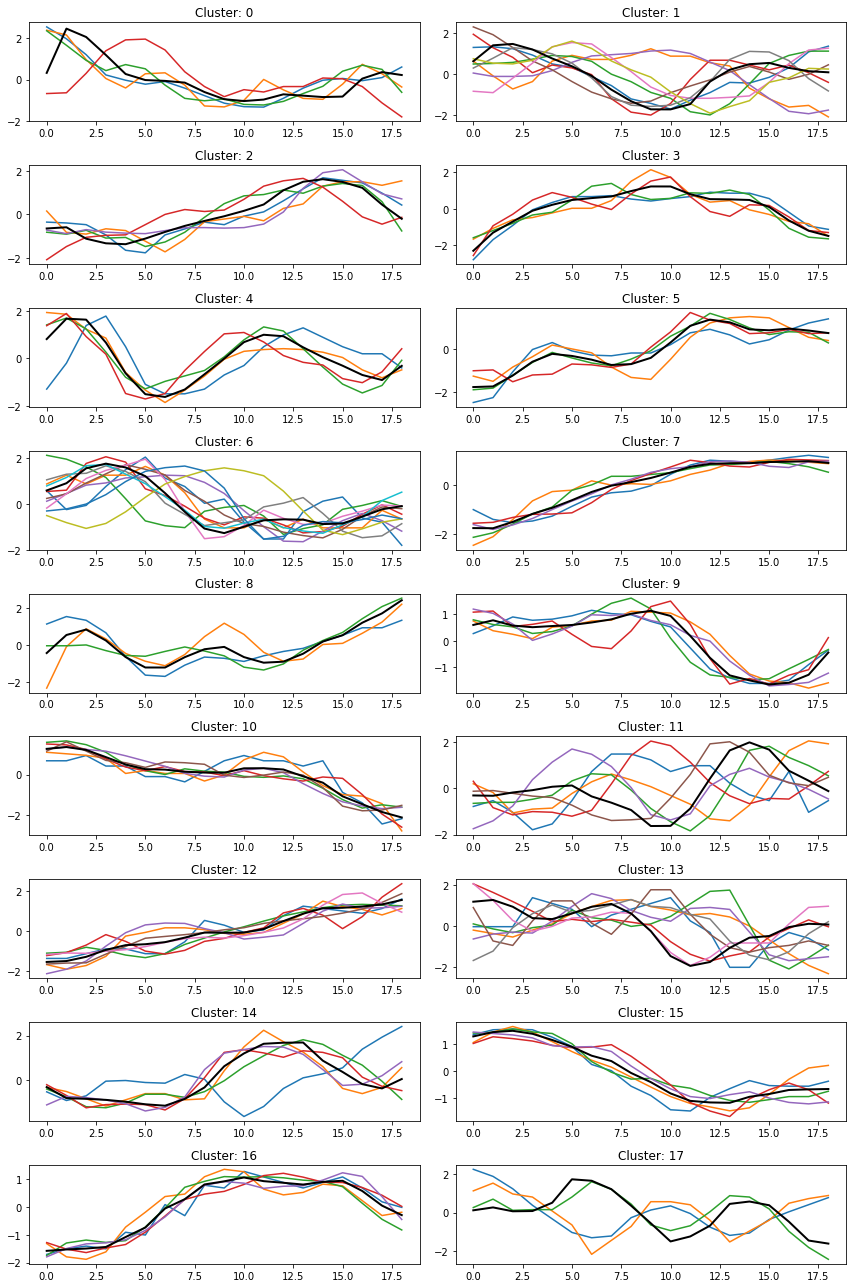

In [134]:
np.random.seed(10)
k = 18
time_series = df.T.values
time_series_zscore = zscore(time_series, axis=1)
clusters = kshape(time_series_zscore, k)

plot_all_clusters(clusters, time_series_zscore)

The results are quite promising! The k-shape algorithm is supposed to be phase invariant, using cross correlation rather than a more  standard distance metric for clustering. This means that it is only looking for similar shapes, and is less concerned about when in the time series those patterns appear.

This means that some of the clusters that look quite erratic are just showing phase shifts between their member time series, see cluster 11 and cluster 17 for example. Although it should also be noted that as our time series are relatively short (only 18 samples) that some patterns appear to be truncated. 

Another important point is we require a **standardized** input as the algorithm only cares about shapes, regardless of scale, and so similar time series do not necessarily have similar input values, but instead have a similar fluctuation in values. 

This is illustrated below with cluster 10 where we plot both the raw unstandardized input, and the standardized input (**z-score**)  used for clustering along with the cluster centroid (the same as the above plots) 

Initially we would not associate a team like Manchester United, that consistently finishes near the top of the 1st division with a team like Stockport County which is free-falling through the divisions. However all these teams show a standardized downwards trend and this turns out to be true. For Manchester United who would consistently finish 1st or 2nd, in recent years they have struggled to finish in the top four and because of their usual consistency (low variance) even a small drop-off becomes a slump when standardized. 

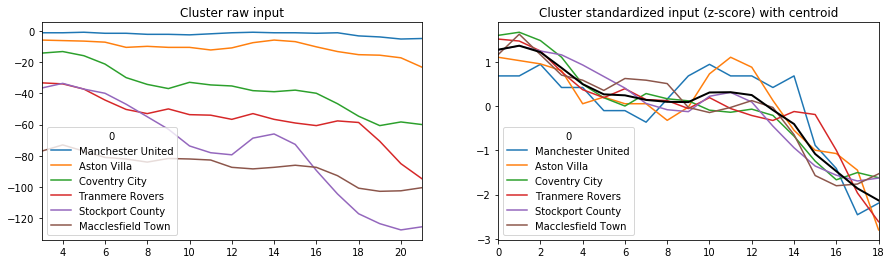

In [184]:
plot_raw_cluster(clusters[10], df)

We can see a similar effect in the cluster below, but this time for teams that have had a general upwards trend. 

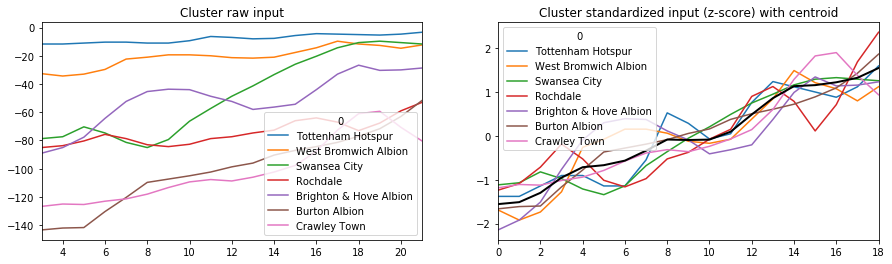

In [181]:
plot_raw_cluster(clusters[12], df)

And lastly here is a cluster of teams which had a good increases but have dropped off in recent years. 

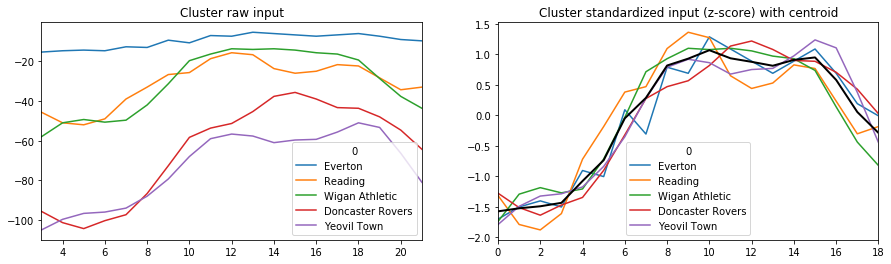

In [182]:
plot_raw_cluster(clusters[16], df)